In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import pandas as pd

import nest_asyncio
nest_asyncio.apply()

tff.framework.set_default_context(tff.test.ReferenceExecutor())

### Load MNIST dataset

In [2]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

##### Dataset is split among 10 clients.
##### Each client 1-10
##### Output = A list of list(Outer - Client, Inner - Data)
##### In each client's data, x:Images, y:Digit labels

In [3]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

###### First image(flattened) of the first batch of the client 5

In [4]:
federated_train_data[5][0]['x'][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

###### The label of that image

In [5]:
federated_train_data[5][0]['y'][0]

5

###### Summary of what data each client got

In [6]:
def clientDataSummary(dataset):
    summary = []
    l = ["Client ID", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    for i in range(10):
        y_dict = {i : 0 for i in l} 
        y_dict["Client ID"] = i+1
        for data in dataset[i]:
            for y in data['y']:
                y_dict[y] = y_dict[y]+1
#                 if y not in y_dict.keys():
#                     y_dict[y] = 1
#                 else:
#                     y_dict[y] = y_dict[y]+1
        summary.append(y_dict)
    return summary

In [7]:
clientDataSummaryTraining = clientDataSummary(federated_train_data)
clientDataSummaryTraining

[{'Client ID': 1,
  0: 1000,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 2,
  0: 0,
  1: 1000,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 3,
  0: 0,
  1: 0,
  2: 1000,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 4,
  0: 0,
  1: 0,
  2: 0,
  3: 1000,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 5,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 1000,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 6,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 1000,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 7,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 1000,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 8,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 1000,
  8: 0,
  9: 0},
 {'Client ID': 9,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 1000,
  9: 0},
 {'Client ID': 10,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,

In [8]:
clientDataSummaryTesting = clientDataSummary(federated_test_data)
clientDataSummaryTesting

[{'Client ID': 1,
  0: 980,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 2,
  0: 0,
  1: 1000,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 3,
  0: 0,
  1: 0,
  2: 1000,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 4,
  0: 0,
  1: 0,
  2: 0,
  3: 1000,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 5,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 982,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 6,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 892,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 7,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 958,
  7: 0,
  8: 0,
  9: 0},
 {'Client ID': 8,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 1000,
  8: 0,
  9: 0},
 {'Client ID': 9,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 974,
  9: 0},
 {'Client ID': 10,
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8:

###### Client data distribution in tabular format

In [9]:
table_training = pd.DataFrame(clientDataSummaryTraining)
table_training

,Client ID,0,1,2,3,4,5,6,7,8,9
0,1,1000,0,0,0,0,0,0,0,0,0
1,2,0,1000,0,0,0,0,0,0,0,0
2,3,0,0,1000,0,0,0,0,0,0,0
3,4,0,0,0,1000,0,0,0,0,0,0
4,5,0,0,0,0,1000,0,0,0,0,0
5,6,0,0,0,0,0,1000,0,0,0,0
6,7,0,0,0,0,0,0,1000,0,0,0
7,8,0,0,0,0,0,0,0,1000,0,0
8,9,0,0,0,0,0,0,0,0,1000,0
9,10,0,0,0,0,0,0,0,0,0,1000


In [10]:
table_testing = pd.DataFrame(clientDataSummaryTesting)
table_testing

,Client ID,0,1,2,3,4,5,6,7,8,9
0,1,980,0,0,0,0,0,0,0,0,0
1,2,0,1000,0,0,0,0,0,0,0,0
2,3,0,0,1000,0,0,0,0,0,0,0
3,4,0,0,0,1000,0,0,0,0,0,0
4,5,0,0,0,0,982,0,0,0,0,0
5,6,0,0,0,0,0,892,0,0,0,0
6,7,0,0,0,0,0,0,958,0,0,0
7,8,0,0,0,0,0,0,0,1000,0,0
8,9,0,0,0,0,0,0,0,0,974,0
9,10,0,0,0,0,0,0,0,0,0,1000


###### Client data distribution histogram

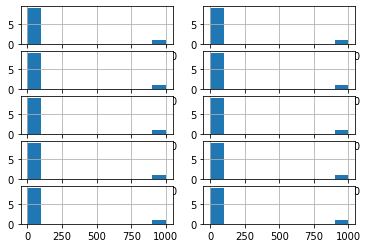

In [11]:
for i in range(1, 11):
    plt.subplot(5, 2, i)
    table_training.loc[:,(i-1)].T.hist()
plt.show()

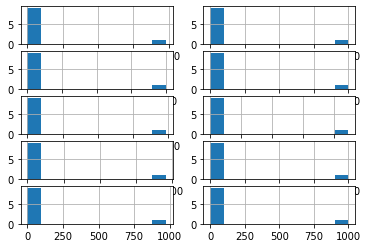

In [12]:
for i in range(1, 11):
    plt.subplot(5, 2, i)
    table_testing.loc[:,(i-1)].T.hist()
plt.show()

###### Defining a loss function

In [13]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [14]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [15]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

In [16]:
# str(batch_loss.type_signature)

In [17]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025854

###### Gradient descent on a single batch

In [18]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
# str(batch_train.type_signature)

In [20]:
# model = initial_model
# losses = []
# for _ in range(5):
#     model = batch_train(model, sample_batch, 0.1)
#     losses.append(batch_loss(model, sample_batch))

In [21]:
# losses

###### Gradient descent on a sequence of local data

In [22]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

   # Mapping function to apply to each batch.
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [23]:
# str(local_train.type_signature)

In [24]:
# locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

###### Local evaluation 

In [25]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [26]:
# str(local_eval.type_signature)

In [27]:
# print('initial_model loss =', local_eval(initial_model,
#                                          federated_train_data[5]))
# print('locally_trained_model loss =',
#       local_eval(locally_trained_model, federated_train_data[5]))

In [28]:
# print('initial_model loss =', local_eval(initial_model,
#                                          federated_train_data[0]))
# print('locally_trained_model loss =',
#       local_eval(locally_trained_model, federated_train_data[0]))

In [29]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

In [30]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

In [31]:
# print('initial_model loss =', federated_eval(initial_model,
#                                              federated_train_data))
# print('locally_trained_model loss =',
#       federated_eval(locally_trained_model, federated_train_data))

In [32]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

In [33]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.45725440979004


In [34]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767
